# Introduction


Hello everyone! Welcome to the second tutorial in the [Building models in JAX](https://github.com/AakashKumarNain/building_models_in_JAX) series. We will extend our [first tutorial](https://www.kaggle.com/aakashnain/building-models-in-jax-part1-stax/) where we used `Stax` to build a `CIFAR-10` classifier purely in JAX. This time we will use one of the most famous and most widely used high-level libraries for JAX for building a classifier. In this notebook, we will be taking a deep dive into **[Flax](https://flax.readthedocs.io/en/latest/)**. I will again list down all the things that we are going to do in this notebook: 

1. Use the Cifar-10 dataset for training the classifier
2. Build a classifier in Flax
3. Data augmentation purely in JAX
4. Create a custom training/testing loop in the most simplified manner
5. Discuss the pros and cons of this approach

If you don't know the fundamentals of TensorFlow/JAX, you can use these [notebooks](https://www.kaggle.com/general/296640) to get a solid understanding of both the frameworks. Without any further due, let's start!

In [1]:
import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from flax.core import freeze, unfreeze
import jax
import jax.numpy as jnp
from jax import random
from jax import make_jaxpr
from jax.config import config
from jax import value_and_grad
from jax import grad, vmap, pmap, jit

import optax
from flax import linen as nn
from flax.training import train_state

np.random.seed(1234)
%config IPCompleter.use_jedi = False

# Dataset

We will use the Cifar-10 dataset for this experiment. You can download it or add it from Kaggle as well, but I am directly importing it from the available `tf.keras.datasets` for the sake of simplicity and brevity

In [3]:
# The downloaded dataset consists of two tuples. The first
# tuple represents the training data consisting of pairs of images
# and labels. Similary, the second tuple consists of validation/test data.
# I will use the second tuple as the validation data for this demo

(x_train, y_train), (x_valid, y_valid) = cifar10.load_data()
print(f"\nNumber of training samples: {len(x_train)} with samples shape: {x_train.shape[1:]}")
print(f"Number of validation samples: {len(x_valid)} with samples shape: {x_valid.shape[1:]}")


# There are 10 classes in this dataset. We will create a dictionary for
# mapping the names of the classes represented by the integer labels
# Labels dictionary
labels_dict = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}


Number of training samples: 50000 with samples shape: (32, 32, 3)
Number of validation samples: 10000 with samples shape: (32, 32, 3)


# Plotting Utility

Whenever we deal with image data, a few steps related to data processing are always the same. The two most common of them are:
1. Check the raw image data and the corresponding labels to ensure that the labels are correct
2. Plot the augmented samples to ensure that the image augmentation pipeline is correct

Both the steps require the plotting of the samples. Hence, we will define a plotting utility to reuse for these steps.

In [4]:
def plot_samples(x, y, figsize=(12, 8), num_rows=5, num_columns=3, title=None):
    """Plots images with labels as desrciptons.
    
    Args:
        x: Batch of images represented as ndarray
        y: Batch of correspondning labels
        figsize: Plot size
        num_rows: Number of rows in the plot
        num_columns: Number of columns in the plot
        title: Title of the plot (if any). Defaults to `None`
    """
    
    if len(x) != len(y):
        raise ValueError("Number of images and number of labels don't match!")
    
    _, ax = plt.subplots(num_rows, num_columns, figsize=figsize)
    
    for i in range(num_rows * num_columns):
        try:
            img = x[i]
            label = str(y[i])
            ax[i // num_columns, i % num_columns].imshow(img)
            ax[i // num_columns, i % num_columns].set_title(label)
            ax[i // num_columns, i % num_columns].axis("off")
        except:
            pass
    
    if title:
        plt.suptitle(str(title))
    plt.show()

# Sanity Check

Now that we have our plotting utility, the first sanity check we will do is check the image data and the corresponding labels. To do so, we will perform the following steps:

1. We will randomly choose `n` numbers in the range `[0, len(training data) - 1]`
2. Based on the chosen indices, we will extract the images and the corresponding samples from the training data
3. Plot the randomly selected samples using our plotting utility for the sanity check

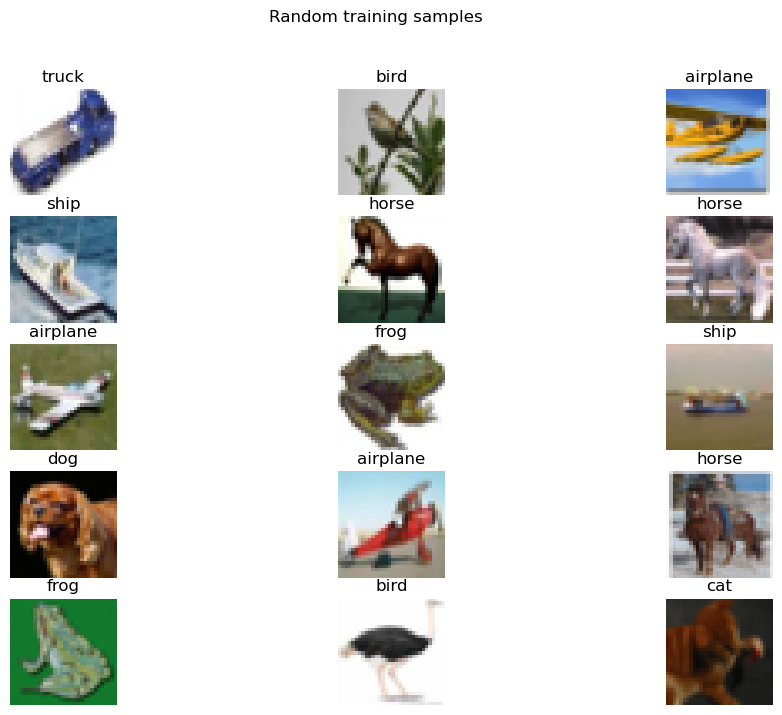

In [5]:
# Select random indices in the range [0, len(training_data) - 1]
sample_size = 15
indices = np.arange(len(x_train))
random_idx = np.random.choice(indices, size=(sample_size,))

# Get the data corresponding to the selected indices
randomly_selected_images = x_train[random_idx]
randomly_selected_labels = y_train[random_idx]

# We will map the integer labels to the class names using our labels dict
randomly_selected_labels = [labels_dict[i[0]] for i in randomly_selected_labels]

# Plot randomly selected samples to check the data
plot_samples(
    x=randomly_selected_images,
    y=randomly_selected_labels,
    title="Random training samples"
)

# Data Augmentation

We will apply image augmentation, and that too, purely in JAX. For augmentation, we will be using three different augmentation techniques:
1. Random rotation by 90 degrees
2. Random horizontal flips
3. Random vertical flips

For each of these augmentations:
1. We will define a function that will either return an augmented image or an identity image
2. Use [**vmap**](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-8-vmap-pmap#Data-Augmentation---Building-a-simple,-fast,-and-scalable-pipeline) to do augmentation in batches
3. [**jit**](https://www.kaggle.com/aakashnain/tf-jax-tutorials-part-7-jit-in-jax) the whole augmentation pipeline

In [6]:
def rotate_90(img):
    """Rotates an image by 90 degress k times."""
    return jnp.rot90(img, k=1, axes=(0, 1))


def identity(img):
    """Returns an image as it is."""
    return img


def flip_left_right(img):
    """Flips an image left/right direction."""
    return jnp.fliplr(img)


def flip_up_down(img):
    """Flips an image in up/down direction."""
    return jnp.flipud(img)


def random_rotate(img, rotate):
    """Randomly rotate an image by 90 degrees.
    
    Args:
        img: Array representing the image
        rotate: Boolean for rotating or not
    Returns:
        Rotated or an identity image
    """

    return jax.lax.cond(rotate, rotate_90, identity, img)


def random_horizontal_flip(img, flip):
    """Randomly flip an image vertically.
    
    Args:
        img: Array representing the image
        flip: Boolean for flipping or not
    Returns:
        Flipped or an identity image
    """
    
    return jax.lax.cond(flip, flip_left_right, identity, img)
    
    
def random_vertical_flip(img, flip):
    """Randomly flip an image vertically.
    
    Args:
        img: Array representing the image
        flip: Boolean for flipping or not
    Returns:
        Flipped or an identity image
    """
    
    return jax.lax.cond(flip, flip_up_down, identity, img)





# All the above function are written to work on a single example. 
# We will use `vmap` to get a version of these functions that can
# operate on a batch of images. We will also add the `jit` transformation
# on top of it so that the whole pipeline can be compiled and executed faster
random_rotate_jitted = jit(vmap(random_rotate, in_axes=(0, 0)))
random_horizontal_flip_jitted = jit(vmap(random_horizontal_flip, in_axes=(0, 0)))
random_vertical_flip_jitted = jit(vmap(random_vertical_flip, in_axes=(0, 0)))

@jax.jit
def augment_images(images, key):
    """Augment a batch of input images.
    
    Args:
        images: Batch of input images as a jax array
        key: Seed/Key for random functions for generating booleans
    Returns:
        Augmented images with the same shape as the input images
    """
    
    batch_size = len(images)
    
    # 1. Rotation
    key, subkey = random.split(key)
    rotate = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_rotate_jitted(images, rotate)
    
    # 2. Flip horizontally
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_horizontal_flip_jitted(augmented, flip)
    
    # 3. Flip vertically
    key, subkey = random.split(key)
    flip = random.randint(key, shape=[batch_size], minval=0, maxval=2)
    augmented = random_vertical_flip_jitted(augmented, flip)
    
    return augmented

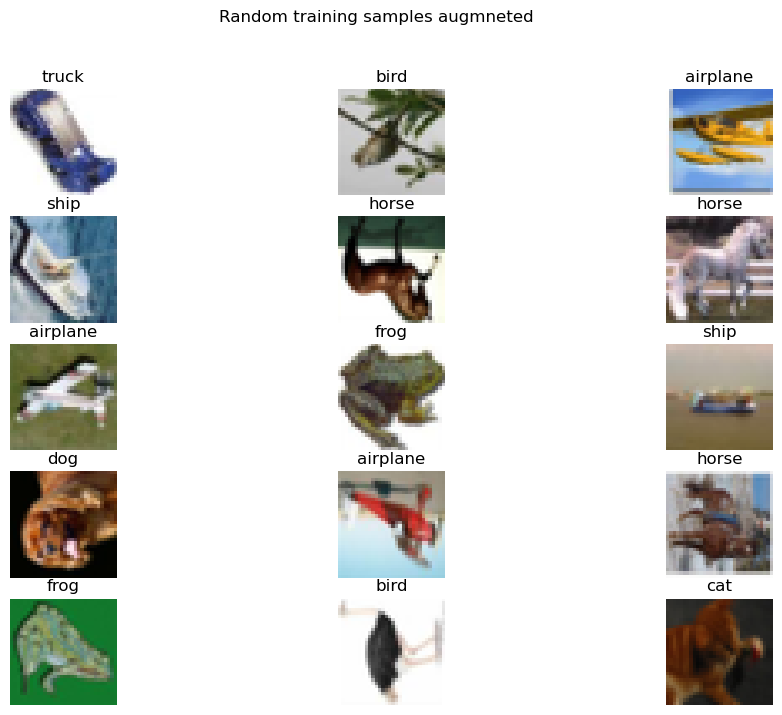

In [7]:
# Let's plot the augmented version of our randomly selected samples.
# This will help us ensure that our augmentation pipeline is working
# as expected.

# Augment the images we selected randomly
randomly_selected_images_augmented = augment_images(
    randomly_selected_images, key=random.PRNGKey(0)
)

# Plot the augmeneted samples
plot_samples(
    x=randomly_selected_images_augmented,
    y=randomly_selected_labels,
    title="Random training samples augmneted"
)

Perfect! The augmentation pipeline is working as expected. Let's move to the next step.

# Data Preprocessing

For data preprocessing, we will apply these two things:
1. We will normalize the image data so that the pixel values for each image is in the range `[0, 1]`
2. We will one-hot encode our labels

In [8]:
# Normalize the image pixels in the range [0, 1]
x_train_normalized = jnp.array(x_train / 255.)
x_valid_normalized = jnp.array(x_valid / 255.)

# One hot encoding applied to the labels. We have 10
# classes in the dataset, hence the depth of OHE would be 10
y_train_ohe = jnp.squeeze(jax.nn.one_hot(y_train, num_classes=10))
y_valid_ohe = jnp.squeeze(jax.nn.one_hot(y_valid, num_classes=10))

print(f"Training images shape:   {x_train_normalized.shape}  Labels shape: {y_train_ohe.shape}")
print(f"Validation images shape: {x_valid_normalized.shape}  Labels shape: {y_valid_ohe.shape}")

Training images shape:   (50000, 32, 32, 3)  Labels shape: (50000, 10)
Validation images shape: (10000, 32, 32, 3)  Labels shape: (10000, 10)


# Data Generator

Now that we have preprocessed our dataset, we need to define our data generator that will stream batches of data, where each batch is a pair of images and the corresponding labels. We will apply data augmentation to the training data only.

In [9]:
def data_generator(images, labels, batch_size=128, is_valid=False, key=None):
    """Generates batches of data from a given dataset.
    
    Args:
        images: Image data represented by a ndarray
        labels: One-hot enocded labels
        batch_size: Number of data points in a single batch
        is_valid: (Boolean) If validation data, then don't shuffle and
                    don't apply any augmentation
        key: PRNG key needed for augmentation
    Yields:
        Batches of images-labels pairs
    """
    
    # 1. Calculate the total number of batches
    num_batches = int(np.ceil(len(images) / batch_size))
    
    # 2. Get the indices and shuffle them
    indices = np.arange(len(images))
    
    if not is_valid:
        if key is None:
             raise ValueError("A PRNG key is required if `aug` is set to True")
        else:
            np.random.shuffle(indices)
    
    for batch in range(num_batches):
        curr_idx = indices[batch * batch_size: (batch+1) * batch_size]
        batch_images = images[curr_idx]
        batch_labels = labels[curr_idx]
        
        if not is_valid: 
            batch_images = augment_images(batch_images, key=key)
        yield batch_images, batch_labels
        
        

# Sanity Check: To make sure that the batches generated by the data
# generator are of correct size, we will just pull a batch of data and
# will check the shape of the images and the labels

sample_data_gen = data_generator(
    images=x_train_normalized,
    labels=y_train_ohe,
    batch_size=8,
    is_valid=False,
    key=random.PRNGKey(0)
)

sample_batch_images, sample_batch_labels = next(sample_data_gen)
print("Batch of images is of shape: ", sample_batch_images.shape)
print("Batch of labels is of shape: ", sample_batch_labels.shape)

# Clean up unnecessary objects
del sample_data_gen, sample_batch_images, sample_batch_labels

Batch of images is of shape:  (8, 32, 32, 3)
Batch of labels is of shape:  (8, 10)


# Model

This time we will be using Flax to build our CNN model. The API design for Flax deserves a separate discussion (which I probably will do on [Twitter](https://twitter.com/A_K_Nain)). Here I will list the basic things that you need to know to build neural networks in Flax.

1. [Module](https://flax.readthedocs.io/en/latest/flax.linen.html#flax.linen.Module) is the base class for building NNs in Flax. You need to inherit this class for writing layers or models.
2. Modules can have submodules e.g. a bunch of layers inside a model. There are two ways to define submodules. The first one is to declare them by overriding the`setup(...)` method and then calling them inside the `__call__(...)` method, much like how you do in Tensorflow custom models and in Pytorch. The second one is to directly declare and call the submodules in the `__call__(...)` method by decorating it with the `@nn.compact` decorator. Both the approaches have their pros and cons, and you **should** read [this](https://flax.readthedocs.io/en/latest/design_notes/setup_or_nncompact.html) to understand it in detail.
3. Once the model is defined, we will then define:
    * The loss function
    * The evaluation metric
    * Train step
    * Test step
    * Training and evaluation loops
    

**Note:** Please read the code comments in the next section carefully. They will help you understand the above steps in detail.

In [10]:
from typing import Any


class resNet(nn.Module):
    
    @nn.compact
    def __call__(self, inputs, IsTrain):
        x = inputs
        x = nn.Conv(x.shape[-1], (3, 3), padding="SAME",use_bias=False)(x)
        x = nn.Dropout(0.1,deterministic=not IsTrain)(x)
        x = nn.BatchNorm(use_running_average=not IsTrain)(x)
        x = nn.gelu(x)
        return inputs + x

class Pool(nn.Module):
    
    @nn.compact
    def __call__(self, inputs, IsTrain):
        x = nn.Conv(inputs.shape[-1]*4, (3, 3), (2, 2), padding="SAME",use_bias=False)(inputs)
        x = nn.Dropout(0.1,deterministic=not IsTrain)(x)
        x = nn.BatchNorm(use_running_average=not IsTrain)(x)
        x = nn.gelu(x)
        return x
    
class CifarCNN(nn.Module):
    """CIFAR-10 Classifier"""
    res_repeats: int = 2
    out_repeats: int = 4
    @nn.compact
    def __call__(self, x, IsTrain):
        # First conv block
        for _ in range(self.out_repeats):
            x = Pool()(x,IsTrain)
            for _ in range(self.res_repeats):
                x = resNet()(x,IsTrain)        
        
        # Flatten 
        x = x.reshape(x.shape[0], -1)
        
        # Dense layers
        
        x = nn.Dropout(0.1,deterministic=not IsTrain)(x)
        x = nn.BatchNorm(use_running_average=not IsTrain)(x)
        # We are going to return the logits and not
        # the softamx activations 
        x = nn.Dense(10)(x)
        return x
    
model = CifarCNN()
params = model.init({'params':random.PRNGKey(2),'dropout':random.PRNGKey(3)},jnp.ones([1, 32, 32, 3]),True)
states,params = params.pop('params')
opt = optax.adam(learning_rate=1e-2)
opt_states = opt.init(params)
combined_states = freeze({'params':params,**states})

@jax.jit
def train_one_step(x,y,combined_states,opt_states,dropout_key):
    return_key,dropout_key = random.split(dropout_key,2)
    states,params = combined_states.pop('params')
    def loss_fn(params):
        yhat,new_states = model.apply({'params':params,**states},x,True,\
                                   mutable='batch_stats',rngs={'dropout':dropout_key})
        loss = jnp.mean(optax.softmax_cross_entropy(logits=yhat, labels=y))
        metric = jnp.mean(jnp.argmax(yhat,-1) == jnp.argmax(y,-1))
        return loss,(new_states,metric)
    grad_fn = jax.value_and_grad(loss_fn,has_aux=True)
    (l,(states,metric)),grads = grad_fn(params)
    updates, opt_states = opt.update(grads, opt_states)
    params = optax.apply_updates(params, updates)
    combined_states = freeze({'params':params,**states})
    return combined_states,opt_states,return_key,l,metric

@jax.jit
def eval_one_step(x,y,combined_states):
    yhat = model.apply(combined_states,x,False)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=yhat, labels=y))
    metric = jnp.mean(jnp.argmax(yhat,-1) == jnp.argmax(y,-1))
    return loss, metric

# Training

We have coded every piece required for training and evaluation. We will now define our training loop. 

In [11]:
EPOCHS = 50
BATCH_SIZE = 128
num_train_batches = len(x_train) // BATCH_SIZE
num_valid_batches = len(x_valid) // BATCH_SIZE

key = random.PRNGKey(0)
key, dropout_key = random.split(key)

    
for i in range(EPOCHS):
    train_data_gen = data_generator(x_train_normalized,
                            y_train_ohe,
                            batch_size=BATCH_SIZE,
                            is_valid=False,
                            key=key
                           )
    valid_data_gen = data_generator(x_valid_normalized,
                               y_valid_ohe,
                               batch_size=BATCH_SIZE,
                               is_valid=True
                               )
    # train
    train_batch_loss = 0
    train_batch_metric = 0
    for step in range(num_train_batches):
        x,y = next(train_data_gen)
        combined_states,opt_states,dropout_key,l,metric = train_one_step(x,y,combined_states,opt_states,dropout_key)
        train_batch_loss += l
        train_batch_metric += metric
    train_batch_loss/=num_train_batches
    train_batch_metric/=num_train_batches
    
    # eval
    eval_batch_loss = 0
    eval_batch_metric = 0
    for step in range(num_valid_batches):
        x,y = next(valid_data_gen)
        loss, metric = eval_one_step(x,y,combined_states)
        eval_batch_loss += l
        eval_batch_metric += metric
    eval_batch_loss/=num_valid_batches
    eval_batch_metric/=num_valid_batches
    
    print(f"epoch:{i}, loss: {train_batch_loss:.3f}, acc: {train_batch_metric:.3f}, valid_loss: {eval_batch_loss:.3f}, valid_acc: {eval_batch_metric:.3f}")

epoch:0, loss: 3.086, acc: 0.219, valid_loss: 2.008, valid_acc: 0.238
epoch:1, loss: 2.193, acc: 0.307, valid_loss: 1.813, valid_acc: 0.261
epoch:2, loss: 1.828, acc: 0.375, valid_loss: 1.670, valid_acc: 0.328
epoch:3, loss: 1.642, acc: 0.415, valid_loss: 1.725, valid_acc: 0.378
epoch:4, loss: 1.540, acc: 0.446, valid_loss: 1.434, valid_acc: 0.442
epoch:5, loss: 1.472, acc: 0.470, valid_loss: 1.483, valid_acc: 0.466
epoch:6, loss: 1.404, acc: 0.495, valid_loss: 1.507, valid_acc: 0.470
epoch:7, loss: 1.336, acc: 0.522, valid_loss: 1.496, valid_acc: 0.527
epoch:8, loss: 1.265, acc: 0.548, valid_loss: 1.272, valid_acc: 0.490
epoch:9, loss: 1.215, acc: 0.568, valid_loss: 1.156, valid_acc: 0.524
epoch:10, loss: 1.176, acc: 0.581, valid_loss: 0.989, valid_acc: 0.565
epoch:11, loss: 1.144, acc: 0.594, valid_loss: 1.183, valid_acc: 0.557
epoch:12, loss: 1.119, acc: 0.603, valid_loss: 1.250, valid_acc: 0.545
epoch:13, loss: 1.107, acc: 0.610, valid_loss: 1.176, valid_acc: 0.536
epoch:14, loss: 